## IMPORTS

In [1]:
import yfinance as yf
import json
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, Huber, LogCosh
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import os
import sys

warnings.filterwarnings('default')

# BEST FOR NOW

In [2]:
# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 90% OF DATA IS TRAINING, 7.5% VALIDATION, 2.5% TEST\
# 30 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND AROON OF 14
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'AroonUp', 'AroonDown']

rsi_period=7
aroon_period=14

training_scaler = 0.9
validation_scaler = 0.075
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 85% OF DATA IS TRAINING, 12,5%% VALIDATION, 2.5% TEST
# 30 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND AROON OF 14
# THIS ONE LOOKS MORE IMPRECISE BUT IS RESULTING IN MORE GAINS
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'AroonUp', 'AroonDown']

rsi_period=7
aroon_period=14

training_scaler = 0.85
validation_scaler = 0.125
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 80% OF DATA IS TRAINING, 17.5% VALIDATION, 2.5% TEST
# 40 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND MACD OF 12-26-9
# THIS ONE LOOKS INCREDIBLY PRECISE. BEST GAINS YET (AMAZING??)
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

# SINGLE LSTM(124) BIDIRECTIONAL LAYER WITH 4 FEATURES AND 80% OF DATA IS TRAINING, 17.5% VALIDATION, 2.5% TEST
# 40 weeks
# 100 EPOCHS WITH 32 BATCHES
# RSI OF PERIOD 7 AND MACD OF 12-26-9
# Dense layer 7 predictions
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'RSI', 'MACD_Hist', 'Signal']

# RSI PARAMS
rsi_period=7

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 124
out_pred = 1

## VARIABLES

In [3]:
start_date = pd.to_datetime('19900101').tz_localize('America/New_York')
sequence_length = 2
epochs = 100
batches = 32
features = ['Close', 'macd_hist', 'macd_signal', 'aroon_up', 'aroon_down']



## FUNCTIONS

In [4]:
import pandas as pd

def calculate_rsi(df:pd.DataFrame, period=7):
    delta = df['Close'].diff()
    delta = delta.dropna()

    gain, loss = delta.clip(lower=0), delta.clip(upper=0, lower=None)

    # Use Exponential Moving Average for smoother RSI
    ema_up = gain.ewm(alpha=1/period, min_periods=period).mean()
    ema_down = loss.abs().ewm(alpha=1/period, min_periods=period).mean()

    rs = ema_up / ema_down
    print(rs)
    
    df.loc[df.index[-len(rs):], 'rsi'] = 100 - (100 / (1 + rs))

    return df

def calculate_aroon(df:pd.DataFrame, period=25):
    """
    Compute Aroon Up and Aroon Down for a given DataFrame.

    :param df: DataFrame with 'high_price' and 'low_price' columns.
    :param period: Lookback period for Aroon calculation.
    :return: DataFrame with added 'aroon_up' and 'aroon_down' columns.
    """
    # Computar Aroon Up
    df['aroon_up'] = (df['High']
                            .rolling(window=period+1, min_periods=period)
                            .apply(lambda x: (x.argmax() / period), raw=True)*100
    )
    
    # Computar Aroon Up
    df['aroon_down'] = (df['Low']
                                .rolling(window=period+1, min_periods=period)
                                .apply(lambda x: (x.argmin() / period), raw=True)*100
    )
    
    return df

def add_obv(df):
        df["obv"] = np.where(df["Close"] > df["Close"].shift(1), df["Volume"], 
             np.where(df["Close"] < df["Close"].shift(1), -df["Volume"], 0))
        
        df["obv"] = df["obv"].cumsum()
        
        return df

def add_macd(df:pd.DataFrame, fast_period=fast_period, slow_period=slow_period, signal_period=signal_period):
    """
    Adds MACD, Signal line, and MACD Histogram to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the 'Close' price column.
    fast_period (int): Period for the fast EMA (default is 12).
    slow_period (int): Period for the slow EMA (default is 26).
    signal_period (int): Period for the signal line EMA (default is 9).
    
    Returns:
    pd.DataFrame: DataFrame with added MACD, Signal line, and MACD Histogram columns.
    """
    # Calculate the fast and slow EMAs
    df['EMA_fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # Calculate the MACD
    df['macd'] = df['EMA_fast'] - df['EMA_slow']
    
    # Calculate the Signal line
    df['macd_signal'] = df['macd'].ewm(span=signal_period, adjust=False).mean()
    
    # Calculate the MACD Histogram
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Drop the intermediate EMA columns
    df.drop(columns=['EMA_fast', 'EMA_slow'], inplace=True)
    
    return df


## OBTAINING DATA
1) Tickers
2) Data treatment
3) Sequence creation
4) Data splitting

In [5]:
ticker_list=[]

ticker_list.append(yf.Ticker("GOOG"))
# ticker_list.append(yf.Ticker("GOOG"))

In [6]:
df_scaled_list = []

# RSI PARAMS
rsi_period=14

#AROON PARAMS
aroon_period = 14

#MACD PARAMS
fast_period = 12
slow_period = 26
signal_period = 9

training_scaler = 0.8
validation_scaler = 0.175
test_scaler = 0.025

lstm_complexity = 128*2


# data = ticker.history(period='max')

# data = data[data.index>=start_date]
data = pd.read_csv('MSFT_30.csv', sep=';', index_col=0)
# data.drop(columns=['id', 'ticker_id', 'aroon_down', 'aroon_up', 'macd', 'macd_hist', 'macd_signal', 'rsi', 'created_at', 'updated_at', 'obv'], inplace=True)
data.sort_index(ascending=True, inplace=True)
print(data.head(5))

# data = calculate_rsi(data, rsi_period)
data = calculate_aroon(data, aroon_period)
data = add_macd(data)
# data = add_obv(data)

data.dropna(inplace=True)

data['target'] = data['Close']

print('------')
print(data.tail(20))


                             Open    High     Low   Close   Volume
Date                                                              
2022-02-08 09:30:00-05:00  301.27  303.14  300.10  300.36  2265800
2022-02-08 10:00:00-05:00  300.38  302.40  299.95  301.21  1593871
2022-02-08 10:30:00-05:00  301.22  303.08  300.42  302.34  1235479
2022-02-08 11:00:00-05:00  302.32  304.82  302.28  304.21  1297360
2022-02-08 11:30:00-05:00  304.23  305.13  304.14  304.40  1160990
------
                             Open    High     Low   Close   Volume  \
Date                                                                 
2024-05-23 12:30:00-04:00  432.04  432.10  430.26  430.29   250137   
2024-05-23 13:00:00-04:00  430.29  430.62  429.61  430.10   340650   
2024-05-23 13:30:00-04:00  430.10  430.10  427.19  427.39   492265   
2024-05-23 14:00:00-04:00  427.34  428.01  426.77  427.06   333748   
2024-05-23 14:30:00-04:00  427.05  427.24  425.80  425.95   416768   
2024-05-23 15:00:00-04:00  425.92 

In [7]:
from sklearn.preprocessing import MinMaxScaler

df = data[features + ['target']].copy()  # Ensure df is a separate copy
scaler = MinMaxScaler(feature_range=(0, 10))

print(df.shape)
print(df.head(20))

train_split = int(training_scaler * len(df))  # Training set size
val_split = int(validation_scaler * len(df))  # Validation set size

# Get the actual DateTime indices for training, validation, and test splits
train_index = df.index[:train_split]  # First part for training
val_index = df.index[train_split:train_split+val_split]  # Validation set
test_index = df.index[train_split+val_split:]  # Remaining test set

# Fit the scaler on the training set only
scaler.fit(df.loc[train_index, features])

# Transform and reassign values
df.loc[train_index, features] = scaler.transform(df.loc[train_index, features])
df.loc[val_index, features] = scaler.transform(df.loc[val_index, features])
df.loc[test_index, features] = scaler.transform(df.loc[test_index, features])

print(df.head())


(7665, 6)
                            Close  macd_hist  macd_signal   aroon_up  \
Date                                                                   
2022-02-09 09:30:00-05:00  309.28   0.412986     0.981777  92.857143   
2022-02-09 10:00:00-05:00  307.95   0.474766     1.100469  92.857143   
2022-02-09 10:30:00-05:00  308.65   0.523241     1.231279  85.714286   
2022-02-09 11:00:00-05:00  308.35   0.495824     1.355235  78.571429   
2022-02-09 11:30:00-05:00  307.89   0.410936     1.457969  71.428571   
2022-02-09 12:00:00-05:00  308.67   0.372674     1.551137  64.285714   
2022-02-09 12:30:00-05:00  308.92   0.330968     1.633879  57.142857   
2022-02-09 13:00:00-05:00  308.69   0.257905     1.698355  50.000000   
2022-02-09 13:30:00-05:00  308.59   0.176725     1.742537  42.857143   
2022-02-09 14:00:00-05:00  309.79   0.177273     1.786855  35.714286   
2022-02-09 14:30:00-05:00  309.46   0.130974     1.819598  28.571429   
2022-02-09 15:00:00-05:00  310.02   0.114237     1.848

In [8]:
def create_sequences(data, lookback=60, forecast_horizon=2):
    sequences = []
    targets = []
    
    for i in range(lookback, len(data) - forecast_horizon + 1):  # Prevent index out of range
        sequences.append(data.iloc[i - lookback:i].values)  # Input sequence of past 'lookback' days
        targets.append(data.iloc[i:i + forecast_horizon]['target'].values)  # Predict next 2 days
    
    return np.array(sequences), np.array(targets)  # Targets will now have shape (samples, 2)


In [9]:
import utils.modelmethods as mm

X, y = create_sequences(df, 3, 1)

print(df.shape)
print(training_scaler)
print(validation_scaler)

X_train, X_val, X_test, y_train, y_val, y_test = mm.obtain_split(X, y, training_scaler, validation_scaler)

print(f'\nX length: {len(X)}')
print(f'Train: {len(X_train)}')
print(f'Val: {len(X_val)}')
print(f'Test: {len(X_test)}')
print(f'Total size: {len(X_train)+len(X_val)+len(X_test)}')

print('\nX Train:')
print(X_train[:3])

print('\ny Train:')
print(y_train[:3])

print(X_train.shape[1])



(7665, 6)
0.8
0.175

X length: 7662
Train: 6128
Val: 1339
Test: 193
Total size: 7660

X Train:
[[[  5.64169536   5.37659278   6.30258847   9.28571429   0.71428571
   309.28      ]
  [  5.56274487   5.50797503   6.43141243   9.28571429   0.71428571
   307.95      ]
  [  5.60429776   5.6110605    6.57338955   8.57142857   0.
   308.65      ]]

 [[  5.56274487   5.50797503   6.43141243   9.28571429   0.71428571
   307.95      ]
  [  5.60429776   5.6110605    6.57338955   8.57142857   0.
   308.65      ]
  [  5.58648937   5.55275585   6.70792731   7.85714286   0.
   308.35      ]]

 [[  5.60429776   5.6110605    6.57338955   8.57142857   0.
   308.65      ]
  [  5.58648937   5.55275585   6.70792731   7.85714286   0.
   308.35      ]
  [  5.55918319   5.3722339    6.81943144   7.14285714   0.
   307.89      ]]]

y Train:
[[308.35]
 [307.89]
 [308.67]]
3


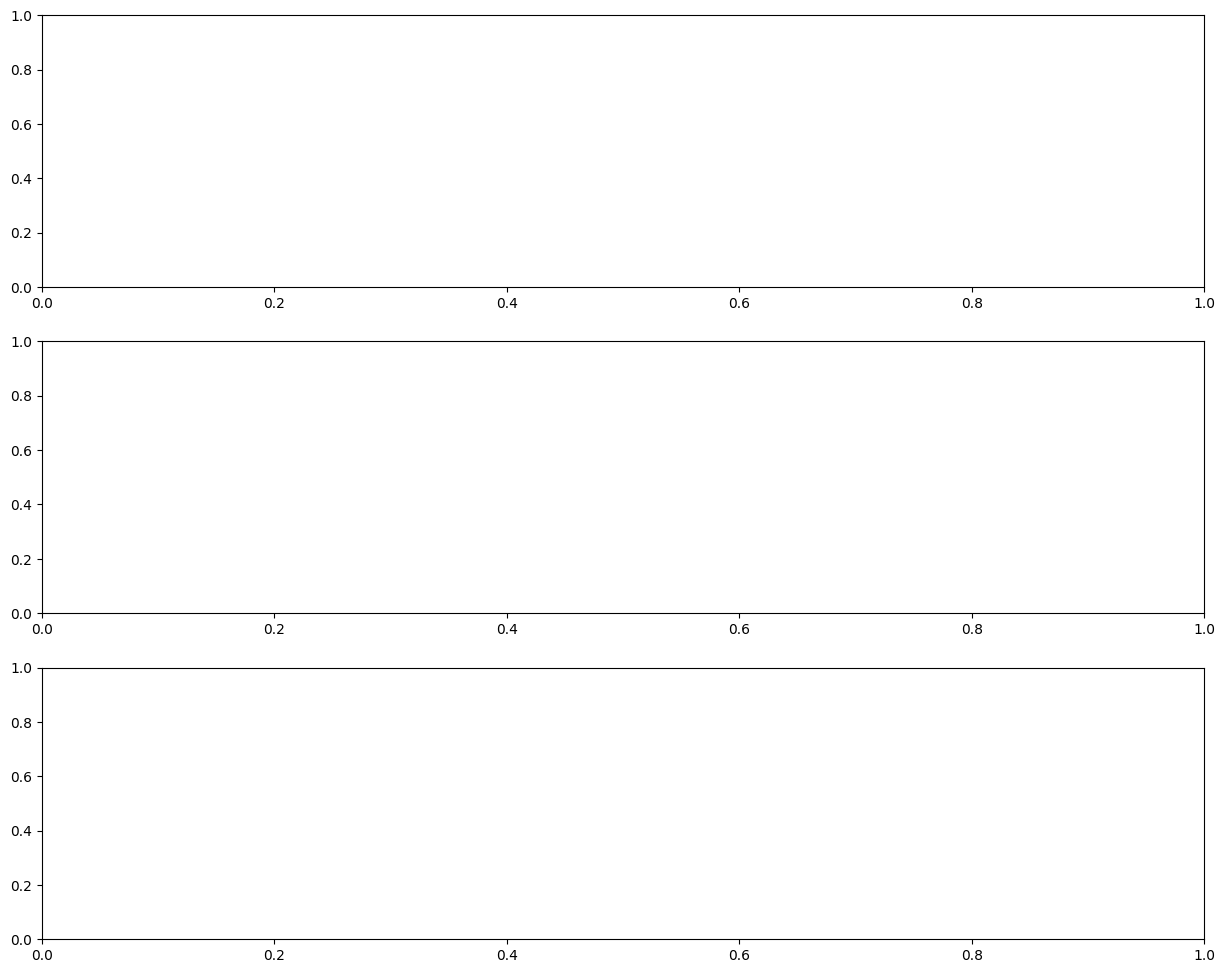

In [10]:
from utils.plotter import LSTMPlotter

plotter = LSTMPlotter(rows=3, cols=1)

None

## GENERATE MODEL

In [16]:

for i in range(1,3):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
    # for i in range(1,3):
    model.add(Bidirectional(LSTM(units=lstm_complexity, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(units=lstm_complexity, activation='relu')))
    # model.add(Bidirectional(LSTM(units=32)))
    # model.add(Bidirectional(LSTM(units=lstm_complexity)))
    model.add(Dropout(0.3))
    # model.add(LSTM(units=50, return_sequences=False))
    # model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='linear'))

    # print(model.summary())

    cp_path = f'model_cp_{i}.keras'
    if os.path.exists(cp_path):
        os.remove(cp_path)
        
    cp = ModelCheckpoint(cp_path, save_best_only=True)
    model.compile(optimizer='adam', loss='mape', metrics=['mse', 'mape'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batches, callbacks=[cp,early_stopping])

    # # Load the best model
    # model.load_weights(cp_path)
    # # Evaluate the model on the test set
    # test_loss = model.evaluate(X_test, y_test)
    # print(test_loss)
    
    # # Make predictions on the test set
    # y_pred = model.predict(X_test)
        
    # plotter.add_plot(y_test, y_pred, cp_path)
    
    # None

Epoch 1/100


c:\Users\nacho\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


KeyboardInterrupt: 

In [12]:
plotter.show()

<Figure size 640x480 with 0 Axes>

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


# Compute Metrics
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(y_test, color='blue', label='Actual Closing Price')
plt.plot(y_pred, color='red', label='Predicted Closing Price')

# Add Title and Labels
plt.gca().set_xticklabels(df[train_split+val_split:].index)
plt.title('Stock Closing Price Prediction', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Closing Price', fontsize=16)
plt.legend(fontsize=14)

# Display metrics on the plot
metrics_text = f"MAPE: {mape:.2f}%\nRMSE: {rmse:.2f}\nMSE: {mse:.2f}"
plt.text(2, max(y_test) * 0.995, metrics_text, fontsize=18, color='black', 
         bbox=dict(facecolor='white', alpha=0.6))

# Show plot
plt.show()


NameError: name 'y_pred' is not defined

## SIGNALING

In [275]:
test=[1,2,3]
print(type(y_test))

def duplicate_features(data, n_features=len(features)):
    return np.tile(data.reshape(-1, 1), n_features)

# Duplicate y_test and y_pred to have 4 identical columns
y_test_duplicated = duplicate_features(y_test)
y_pred_duplicated = duplicate_features(y_pred)

# Perform inverse transform
y_test_original_duplicated = scaler.inverse_transform(y_test_duplicated)
y_pred_original_duplicated = scaler.inverse_transform(y_pred_duplicated)

# Extract the first column
y_test_original = y_test_original_duplicated[:, 0]
y_pred_original = y_pred_original_duplicated[:, 0]


# Create DataFrame
# y_pred = y_pred.flatten()
n_df = pd.DataFrame({
    'actual': y_test_original,
    'predicted': y_pred_original
})

# Generate trading signals
n_df['buy_signal'] = n_df['predicted'].diff().shift(-2) > 0
n_df['sell_signal'] = n_df['predicted'].diff().shift(-2) < 0

# # Initialize variables for tracking trades
# position = 0  # 1 for holding, 0 for not holding
# buy_price = 0
# total_profit = 0
# trades = []


# # Simulate trades
# for i in range(len(df)):
#     if df['buy_signal'][i] and position == 0:
#         # Buy
#         position = 1
#         buy_price = df['actual'][i]
#     elif df['sell_signal'][i] and position == 1:
#         # Sell
#         position = 0
#         sell_price = df['actual'][i]
#         profit = sell_price - buy_price
#         total_profit += profit
#         trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'profit': profit})

# Initialize variables for tracking trades
position = 0  # 1 for holding, 0 for not holding
buy_price = 0
total_profit = 0
trades = []

buys = []

# Simulate trades
for i in range(len(df)):
    if n_df['buy_signal'][i]:
        # Buy
        position = 1
        buy_price = n_df['actual'][i]
        buys.append(buy_price)
    elif n_df['sell_signal'][i] and position == 1:
        # Sell
        position = 0
        sell_price = n_df['actual'][i]
        profit = sum(sell_price - x for x in buys)
        total_profit += profit
        trades.append({'buy_price': buy_price, 'sell_price': sell_price, 'profit': profit})
        buys = []

# Identify buy and sell indices
buy_indices = n_df.index[n_df['buy_signal']].tolist()
sell_indices = n_df.index[n_df['sell_signal']].tolist()

# Convert trades to DataFrame for analysis
trades_df = pd.DataFrame(trades)

# Plot the results
plt.figure(figsize=(30, 20))
plt.plot(n_df['actual'], color='blue', label='Actual Closing Price')
plt.plot(n_df['predicted'], color='red', label='Predicted Closing Price')

# Plot buy and sell signals
plt.scatter(buy_indices, n_df['actual'][buy_indices], color='green', marker='^', s=100, label='Buy Signal')
plt.scatter(sell_indices, n_df['actual'][sell_indices], color='orange', marker='v', s=100, label='Sell Signal')

plt.title('Stock Closing Price Prediction with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Stock Closing Price')
plt.legend()

plt.locator_params(axis='x', nbins=2)

plt.show()

# Print performance metrics
print(f"Total Profit: {total_profit:.2f}")
print(f"Number of Trades: {len(trades_df)}")
print(f"Average Profit per Trade: {trades_df['profit'].mean():.2f}")


<class 'numpy.ndarray'>


KeyError: 2